Epoch 1/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 49ms/step - loss: 84.7210 - val_loss: 59.5614
Epoch 2/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - loss: 58.9388 - val_loss: 57.3494
Epoch 3/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 12s 49ms/step - loss: 56.9982 - val_loss: 56.2605
Epoch 4/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 12s 49ms/step - loss: 55.8782 - val_loss: 55.1720
Epoch 5/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 51ms/step - loss: 55.0178 - val_loss: 54.5870


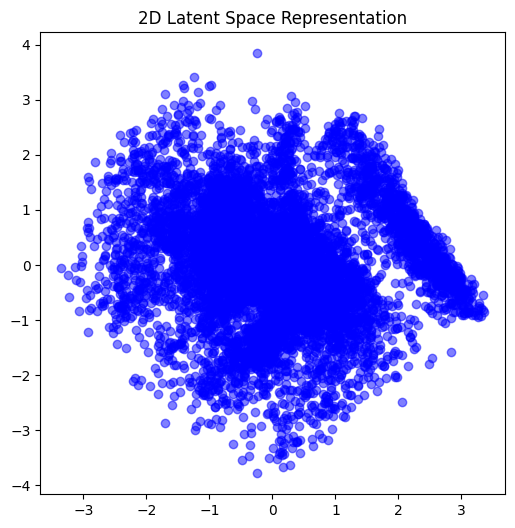

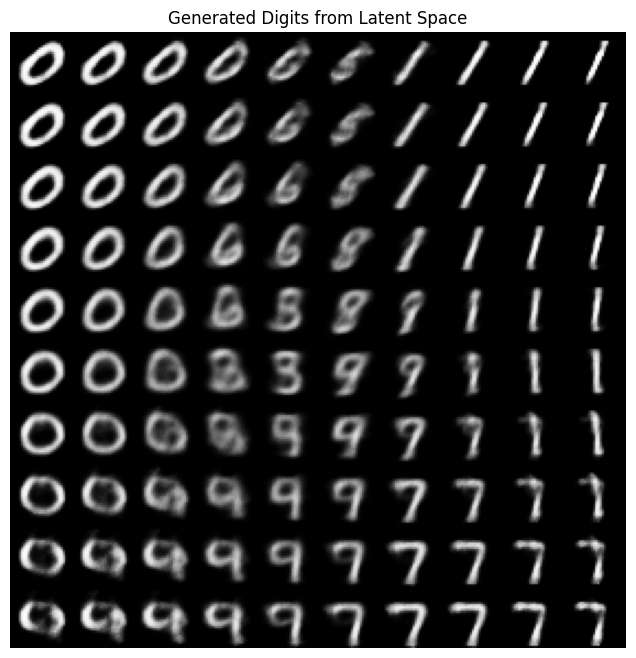

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist

(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype("float32") / 255.
x_test = x_test.astype("float32") / 255.
x_train = x_train.reshape((-1, 784))
x_test = x_test.reshape((-1, 784))

latent_dim = 2

class VAE(tf.keras.Model):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential([
            layers.Input(shape=(784,)),
            layers.Dense(512, activation='relu'),
            layers.Dense(256, activation='relu'),
            layers.Dense(latent_dim * 2)
        ])
        self.decoder = tf.keras.Sequential([
            layers.Input(shape=(latent_dim,)),
            layers.Dense(256, activation='relu'),
            layers.Dense(512, activation='relu'),
            layers.Dense(784, activation='sigmoid')
        ])

    def encode(self, x):
        mean_logvar = self.encoder(x)
        z_mean = mean_logvar[:, :self.latent_dim]
        z_log_var = mean_logvar[:, self.latent_dim:]
        return z_mean, z_log_var

    def reparameterize(self, z_mean, z_log_var):
        eps = tf.random.normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * eps

    def decode(self, z):
        return self.decoder(z)

    def call(self, x):
        z_mean, z_log_var = self.encode(x)
        z = self.reparameterize(z_mean, z_log_var)
        x_recon = self.decode(z)
        recon_loss = tf.reduce_sum(tf.keras.losses.binary_crossentropy(x, x_recon), axis=-1)
        kl_loss = -0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1)
        self.add_loss(tf.reduce_mean(recon_loss + kl_loss))
        return x_recon

vae = VAE(latent_dim)
vae.compile(optimizer='adam')
vae.fit(x_train, x_train, epochs=5, batch_size=256, validation_data=(x_test, x_test))

# Latent space scatter plot
z_mean, _ = vae.encode(x_test)
plt.figure(figsize=(6,6))
plt.scatter(z_mean[:,0], z_mean[:,1], c='blue', alpha=0.5)
plt.title("2D Latent Space Representation")
plt.show()

# Generate digit grid
n = 10
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
grid_x = np.linspace(-3, 3, n)
grid_y = np.linspace(-3, 3, n)[::-1]

for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi, yi]])
        x_decoded = vae.decode(z_sample)
        digit = x_decoded.numpy()[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(8, 8))
plt.imshow(figure, cmap='gray')
plt.axis('off')
plt.title("Generated Digits from Latent Space")
plt.show()
